In [1]:
from __future__ import print_function
import sys
import os
import numpy as np
import google.protobuf as pb
import IPython.display as display
from os.path import expanduser, join
import matplotlib.pyplot as plt
import Image
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# caffe paths and import
home_dir = expanduser('~')
caffe_root = os.path.join(home_dir, 'code/caffe')
sys.path.append(join(caffe_root, "python"))
import caffe
import caffe.draw

### Only one convolution layer

In [3]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_cpu()
net = caffe.Net('../examples/net_surgery/conv.prototxt', caffe.TEST)
print(net.blobs)
print(net.params)

OrderedDict([('data', <caffe._caffe.Blob object at 0x7f583277ced8>), ('conv', <caffe._caffe.Blob object at 0x7f583277b0c8>)])
OrderedDict([('conv', <caffe._caffe.BlobVec object at 0x7f586c2168a0>)])


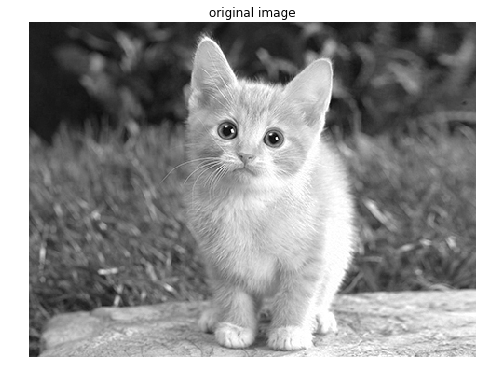

In [4]:
# load image and prepare as a single input batch for Caffe
im = np.array(Image.open('../examples/images/cat_gray.jpg'))
plt.title("original image")
plt.imshow(im)
plt.axis('off')

im_input = im[np.newaxis, np.newaxis, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input

In [5]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv'].data.min(), net.blobs['conv'].data.max()
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv'].data[0, i], vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

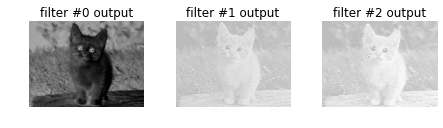

In [6]:
# filter the image with initial 
show_filters(net)

In [7]:
# pick first filter output
conv0 = net.blobs['conv'].data[0, 0]
print("pre-surgery output mean {:.2f}".format(conv0.mean()))

# set first filter bias to 10
net.params['conv'][1].data[0] = 1. # raise bias by 1
net.forward()
print("post-surgery output mean {:.2f}".format(conv0.mean()))

pre-surgery output mean -15.86
post-surgery output mean -14.86


(3, 1, 5, 5)


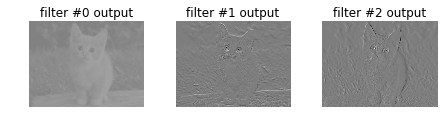

In [8]:
# 0th output is blurred, the 1st picks up horizontal edges, and the 2nd picks up vertical edges
# dimensions
print(net.params['conv'][0].data.shape)
ksize = net.params['conv'][0].data.shape[2:]

# make Gaussian blur
sigma = 1.
y, x = np.mgrid[-ksize[0]//2 + 1:ksize[0]//2 + 1, -ksize[1]//2 + 1:ksize[1]//2 + 1]
g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
gaussian = (g / g.sum()).astype(np.float32)
net.params['conv'][0].data[0] = gaussian

# make Sobel operator for edge detection
net.params['conv'][0].data[1:] = 0.
sobel = np.array((-1, -2, -1, 0, 0, 0, 1, 2, 1), dtype=np.float32).reshape((3,3))
net.params['conv'][0].data[1, 0, 1:-1, 1:-1] = sobel  # horizontal
net.params['conv'][0].data[2, 0, 1:-1, 1:-1] = sobel.T  # vertical

show_filters(net)

### Casting a Classifier into a Fully Convolutional Network

In [9]:
# load the original network and extract the fully connected layers' parameters.
net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)

# fc_params = {name: (weights, biases)}
params = ['fc6', 'fc7', 'fc8']
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print ('%s: weights %s biases %s' % (fc, fc_params[fc][0].shape, fc_params[fc][1].shape))

fc6: weights (4096, 9216) biases (4096,)
fc7: weights (4096, 4096) biases (4096,)
fc8: weights (1000, 4096) biases (1000,)


In [10]:
# fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('../examples/net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)

# conv_params = {name: (weights, biases)}
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print('%s: weights %s biases %s' % (conv, conv_params[conv][0].shape, conv_params[conv][1].shape))

fc6-conv: weights (4096, 256, 6, 6) biases (4096,)
fc7-conv: weights (4096, 4096, 1, 1) biases (4096,)
fc8-conv: weights (1000, 4096, 1, 1) biases (1000,)


The modified net generates a classification map that covers a given input size instead of a single classification. In particular a 8 × 8 classification map on a 451 × 451 input gives 64x the output in only 3x the time.

To do so we translate the InnerProduct matrix multiplication layers of CaffeNet into Convolutional layers. This is the only change: the other layer types are agnostic to spatial size. Convolution is translation-invariant, activations are elementwise operations, and so on. The fc6 inner product when carried out as convolution by fc6-conv turns into a 6 \times 6 filter with stride 1 on pool5. Back in image space this gives a classification for each 227 × 227 box with stride 32 in pixels. Remember the equation for output map / receptive field size, output = (input - kernel_size) / stride + 1, and work out the indexing details for a clear understanding.

The only differences needed in the architecture are to change the fully connected classifier inner product layers into convolutional layers with the right filter size -- 6 x 6, since the reference model classifiers take the 36 elements of pool5 as input -- and stride 1 for dense classification. "Note that the layers are renamed so that Caffe does not try to blindly load the old parameters when it maps layer names to the pretrained model."

The convolution weights are arranged in output × input × height × width dimensions. To map the inner product weights to convolution filters, we could roll the flat inner product vectors into channel × height × width filter matrices, but actually these are identical in memory (as row major arrays) so we can assign them directly.

The biases are identical to those of the inner product.

In [11]:
# transplant
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

In [12]:
# safe model
net_full_conv.save('../examples/net_surgery/bvlc_caffenet_full_conv.caffemodel')

In [15]:
# load input and configure preprocessing
im = caffe.io.load_image('../examples/images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

In [17]:
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print(out['prob'][0].argmax(axis=0))

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


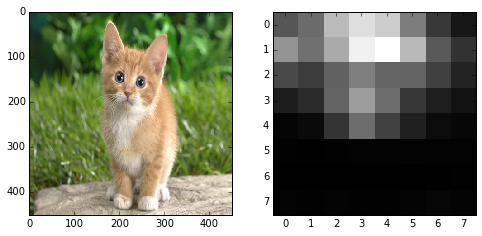

In [18]:
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0,281])

In [19]:
# feature maps
[(k, v.data.shape) for k, v in net_full_conv.blobs.items()]

[('data', (1, 3, 451, 451)),
 ('conv1', (1, 96, 111, 111)),
 ('pool1', (1, 96, 55, 55)),
 ('norm1', (1, 96, 55, 55)),
 ('conv2', (1, 256, 55, 55)),
 ('pool2', (1, 256, 27, 27)),
 ('norm2', (1, 256, 27, 27)),
 ('conv3', (1, 384, 27, 27)),
 ('conv4', (1, 384, 27, 27)),
 ('conv5', (1, 256, 27, 27)),
 ('pool5', (1, 256, 13, 13)),
 ('fc6-conv', (1, 4096, 8, 8)),
 ('fc7-conv', (1, 4096, 8, 8)),
 ('fc8-conv', (1, 1000, 8, 8)),
 ('prob', (1, 1000, 8, 8))]

In [21]:
# parameters
[(k, v[0].data.shape) for k, v in net_full_conv.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6-conv', (4096, 256, 6, 6)),
 ('fc7-conv', (4096, 4096, 1, 1)),
 ('fc8-conv', (1000, 4096, 1, 1))]